# Revenue driver analysis
What customer behaviors actually move revenue?

**Outcome variable**
- total_commission

**Candidate drivers**
- total_trades
- traded_assets (diversification)
- account_lifetime_days
- AUM (Assets Under Management)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
# from sklearn.linear_model import LinearRegression
from db.connection import q

In [26]:
sql = """
WITH asset_diversification AS (
	SELECT
		account_id,
		COUNT(*) AS traded_assets
		
	FROM (
		SELECT DISTINCT ON (t.account_id, t.asset_id) 
			t.account_id, 
			t.asset_id
		FROM "Trade" AS t
		WHERE t.deleted_at IS NULL
	) AS account_traded_assets
	
	GROUP BY account_id
), asset_current_price AS (
	SELECT DISTINCT ON (mkt.asset_id)
		mkt.asset_id,
		mkt.price
	FROM "Market_Price" AS mkt
	WHERE mkt.deleted_at IS NULL
	ORDER BY 
		mkt.asset_id, 
		mkt.price_at DESC
), trade_info AS (
	SELECT
		t.account_id,
		COUNT(*) AS total_count,
		SUM(t.commission) AS total_commission
	FROM "Trade" AS t
	WHERE 
		t.deleted_at IS NULL
	GROUP BY
		t.account_id
), current_positions AS (
	SELECT
		p.account_id,
		SUM(p.quantity * asset_current_price.price) AS aum
	FROM "Position" AS p
	INNER JOIN asset_current_price
	ON p.asset_id = asset_current_price.asset_id
	WHERE
		p.deleted_at IS NULL
	GROUP BY
		p.account_id
)
SELECT 
	trade_info.total_count AS total_trades,
	trade_info.total_commission,
	asset_diversification.traded_assets,
	EXTRACT(EPOCH FROM (NOW() - acc.opened_at)) / 86400 AS lifetime_days,
	current_positions.aum
FROM "Account" AS acc

INNER JOIN trade_info
ON trade_info.account_id = acc.id

INNER JOIN asset_diversification
ON asset_diversification.account_id = acc.id

LEFT JOIN current_positions
ON current_positions.account_id = acc.id

WHERE 
	acc.deleted_at IS NULL;
"""

In [27]:
df = q(sql)
df.head()

,total_trades,total_commission,traded_assets,lifetime_days,aum
0,52,87.1228,10,200.946433,11423.284495
1,122,265.5463,12,814.946433,90622.446689
2,136,201.9093,12,387.946433,51279.844080
3,184,359.3902,12,1436.946433,113983.544197
4,490,658.7020,12,1142.946433,20145.409170


In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137 entries, 0 to 136
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   total_trades      137 non-null    int64  
 1   total_commission  137 non-null    float64
 2   traded_assets     137 non-null    int64  
 3   lifetime_days     137 non-null    float64
 4   aum               135 non-null    float64
dtypes: float64(3), int64(2)
memory usage: 5.5 KB


In [29]:
df[df['aum'].isna()]

,total_trades,total_commission,traded_assets,lifetime_days,aum
110,1,0.1455,1,101.946433,NaN
133,2,3.0809,2,27.946433,NaN


In [30]:
df = df.dropna()

In [31]:
df[df['aum'].isna()]

,total_trades,total_commission,traded_assets,lifetime_days,aum


## Commission distribution analysis

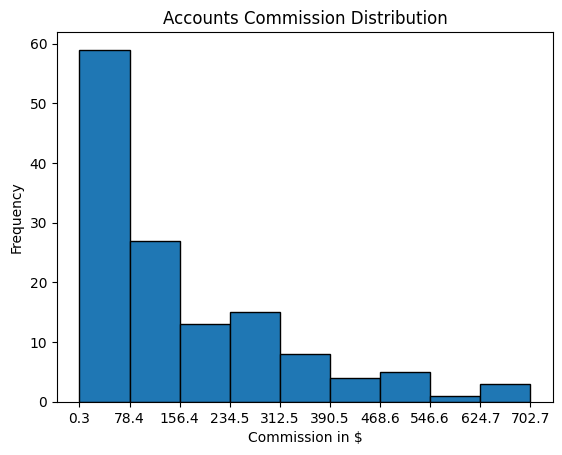

In [ ]:
commission_bins = np.histogram_bin_edges(df['total_commission'], bins='fd')

fig, ax = plt.subplots()
ax.hist(x=df['total_commission'], edgecolor='black', bins=commission_bins)
ax.set_xticks(commission_bins)
ax.set_xlabel('Commission in $')
ax.set_ylabel('Frequency')
ax.set_title('Accounts Commission Distribution')

plt.show()

In [68]:
df['total_commission'].describe()

count    135.000000
mean     154.343633
std      160.550693
min        0.328900
25%       28.456250
50%       90.315100
75%      243.119500
max      702.717800
Name: total_commission, dtype: float64

<Axes: >

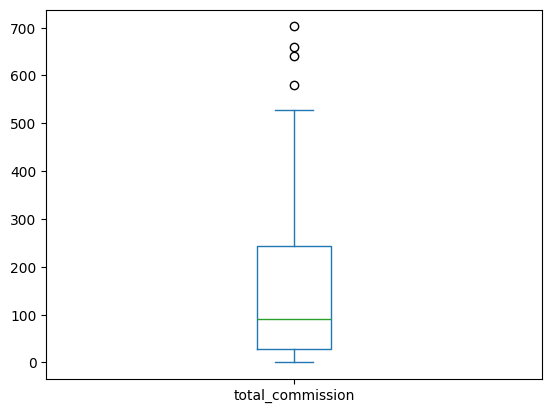

In [80]:
df['total_commission'].plot(kind='box')

We should apply log transformation to the commission feature to mitigate right-skewness. This adjusts the scale to ensure scatterplots represent the data density accurately rather than clustering at the lower bound.

## Total trades distribution analysis

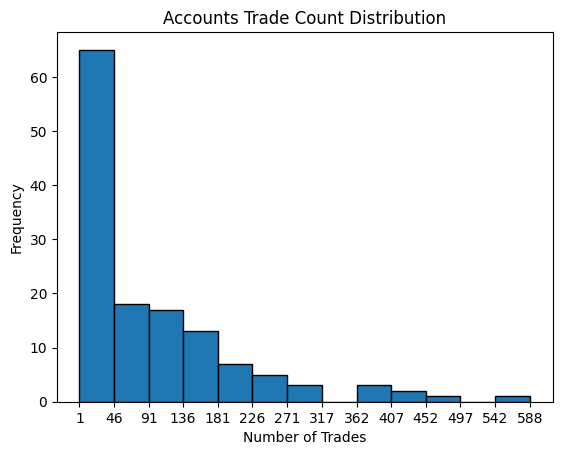

In [ ]:
ttrades_bins = np.floor(np.histogram_bin_edges(df['total_trades'], bins='fd'))

fig, ax = plt.subplots()
ax.hist(x=df['total_trades'], edgecolor='black', bins=ttrades_bins)
ax.set_xticks(ttrades_bins)
ax.set_xlabel('Number of Trades')
ax.set_ylabel('Frequency')
ax.set_title('Accounts Trade Count Distribution')

plt.show()

In [87]:
df['total_trades'].describe()

count    135.000000
mean      94.414815
std      111.367241
min        1.000000
25%       16.000000
50%       50.000000
75%      137.500000
max      588.000000
Name: total_trades, dtype: float64

<Axes: >

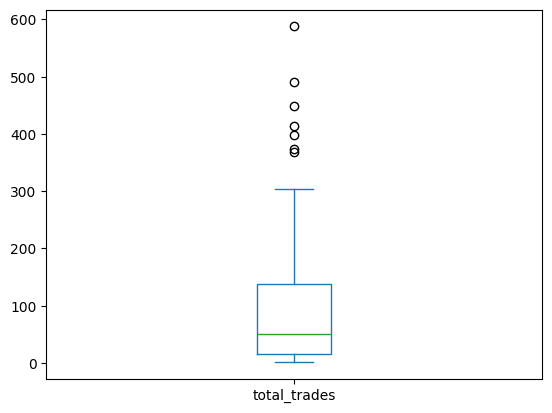

In [89]:
df['total_trades'].plot(kind='box')

We should apply log transformation also to the total trade feature to mitigate right-skewness as we did with the commission feature.

## AUM distribution analysis

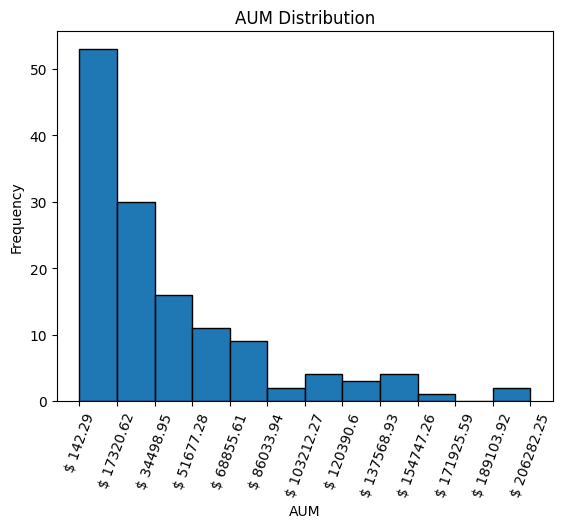

In [ ]:
aum_bins = np.round(np.histogram_bin_edges(df['aum'], bins='fd'), 2)
formatted_ticklabels = [f'$ {value}' for value in aum_bins]

fig, ax = plt.subplots()
ax.hist(x=df['aum'], edgecolor='black', bins=aum_bins)
ax.set_xticks(aum_bins, formatted_ticklabels, rotation=70)
ax.set_xlabel('AUM')
ax.set_ylabel('Frequency')
ax.set_title('AUM Distribution')

plt.show()

<Axes: >

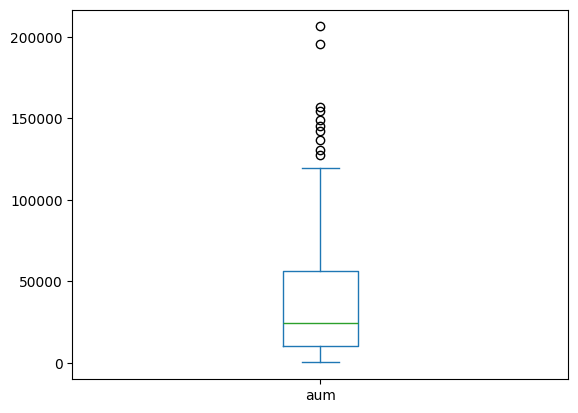

In [99]:
df['aum'].plot(kind='box')

AUM has the same positive skew pattern as commission and total trades.

## Plotting relation between features to explore possible correlations

But due to **heavy** skewed data, we must log-transform before plotting.

In [100]:
df['log_commission'] = np.log1p(df['total_commission'])
df['log_trades'] = np.log1p(df['total_trades'])
df['log_aum'] = np.log1p(df['aum'])

### Commission/Revenue VS Total Trades

<Axes: title={'center': 'Pearson r=0.98\nr_squared=0.95'}, xlabel='log_commission', ylabel='log_trades'>

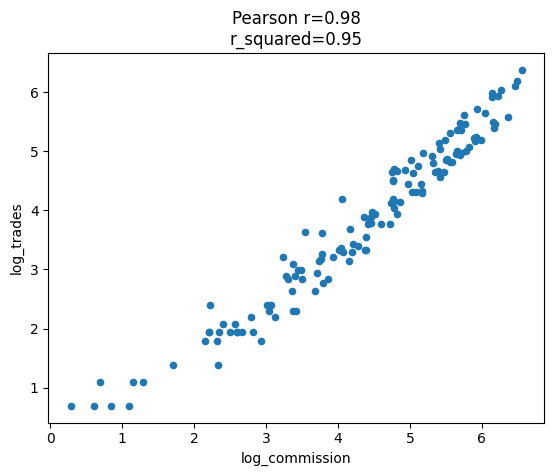

In [112]:
r_commission_trades, _ = pearsonr(df['log_commission'], df['log_trades'])
r_sq = r_commission_trades ** 2

df.plot(kind='scatter', x='log_commission', y='log_trades', 
        title=f'Pearson r={r_commission_trades:.2f}\nr_squared={r_sq:.2f}')

<Axes: xlabel='total_commission', ylabel='aum'>

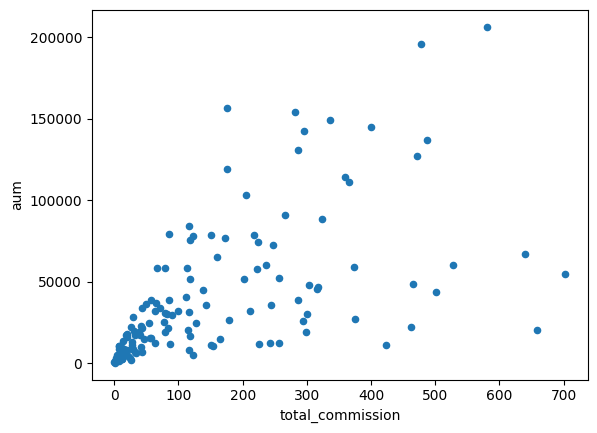

In [49]:
df.plot(kind='scatter', x='total_commission', y='aum')

<Axes: title={'center': 'Commission VS Number of Trades'}, xlabel='log_commission', ylabel='log_trades'>

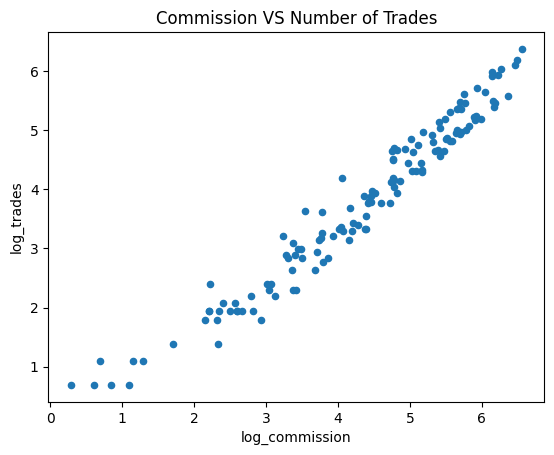

In [60]:
df.plot(kind='scatter', x='log_commission', y='log_trades', title='Commission VS Number of Trades')

<Axes: title={'center': 'Diversification VS Commission'}, xlabel='traded_assets', ylabel='log_commission'>

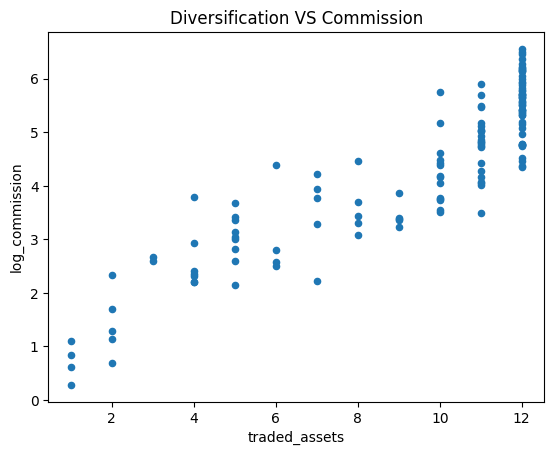

In [63]:
df.plot(kind='scatter', y='log_commission', x='traded_assets', title='Diversification VS Commission')

<Axes: title={'center': 'Commission VS AUM'}, xlabel='log_commission', ylabel='log_aum'>

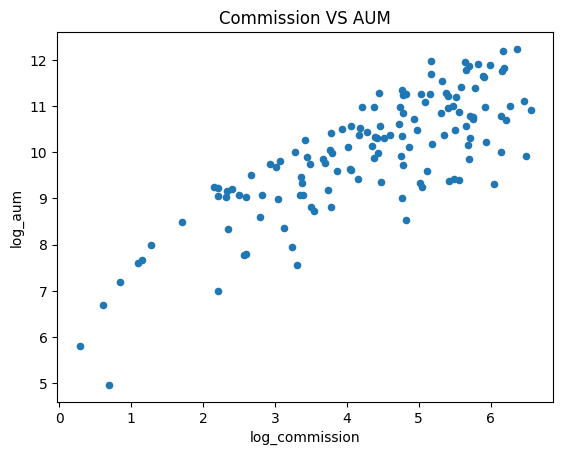

In [65]:
df.plot(kind='scatter', x='log_commission', y='log_aum', title='Commission VS AUM')

**Correlation Matrix**

In [48]:
corr = df[[
    'log_commission',
    'log_trades',
    'log_lifetime',
    'traded_assets',
    'log_aum'
]].corr(method='spearman')
corr

,log_commission,log_trades,log_lifetime,traded_assets,log_aum
log_commission,1.000000,0.980740,0.505431,0.880282,0.751892
log_trades,0.980740,1.000000,0.448130,0.886107,0.671342
log_lifetime,0.505431,0.448130,1.000000,0.371182,0.597929
traded_assets,0.880282,0.886107,0.371182,1.000000,0.669561
log_aum,0.751892,0.671342,0.597929,0.669561,1.000000


In [41]:
corr = df[[
    'log_commission',
    'log_trades',
    'log_lifetime',
    'traded_assets'
]].corr(method='pearson')
corr

,log_commission,log_trades,log_lifetime,traded_assets
log_commission,1.000000,0.976524,0.594056,0.899295
log_trades,0.976524,1.000000,0.529026,0.897179
log_lifetime,0.594056,0.529026,1.000000,0.447969
traded_assets,0.899295,0.897179,0.447969,1.000000
